<a href="https://colab.research.google.com/github/ziyuezhao1/ddpm/blob/main/DDPMnew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 模型

In [ ]:
# no problem
import os
import math
from abc import abstractmethod

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
# 无需更改
def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    Args:
        timesteps (Tensor): a 1-D Tensor of N indices, one per batch element. These may be fractional.
        dim (int): the dimension of the output.
        max_period (int, optional): controls the minimum frequency of the embeddings. Defaults to 10000.

    Returns:
        Tensor: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, t):
        """
        Apply the module to `x` given `t` timestep embeddings.
        """
        pass


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that support it as an extra input.
    """

    def forward(self, x, t):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, t)
            else:
                x = layer(x)
        return x


def norm_layer(channels):
    return nn.GroupNorm(32, channels)


class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )

        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )

        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()


    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(h)
        return h + self.shortcut(x)


class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        """
        Attention block with shortcut

        Args:
            channels (int): channels
            num_heads (int, optional): attention heads. Defaults to 1.
        """
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0

        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B*self.num_heads, -1, H*W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x


class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(stride=2)

    def forward(self, x):
        return self.op(x)


class UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding
    """
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads

        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2

        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout)
        )

        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, timesteps):
        """Apply the model to an input batch.

        Args:
            x (Tensor): [N x C x H x W]
            timesteps (Tensor): a 1-D batch of timesteps.

        Returns:
            Tensor: [N x C x ...]
        """
        hs = []
        # time step embedding
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)


def linear_beta_schedule(timesteps):
    """
    beta schedule
    """
    scale = 10 / timesteps
    beta_start = scale * 0.01
    beta_end = scale * 0.9
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


In [ ]:
betas=linear_beta_schedule(10)
betas

tensor([0.0100, 0.1089, 0.2078, 0.3067, 0.4056, 0.5044, 0.6033, 0.7022, 0.8011,
        0.9000], dtype=torch.float64)

In [ ]:
alphas = 1. - betas
print(alphas)
alphas_cumprod = torch.cumprod(alphas, axis=0)
print(alphas_cumprod)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=0.99)
print(alphas_cumprod_prev)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
print(posterior_variance)

tensor([0.9900, 0.8911, 0.7922, 0.6933, 0.5944, 0.4956, 0.3967, 0.2978, 0.1989,
        0.1000], dtype=torch.float64)
tensor([9.9000e-01, 8.8220e-01, 6.9890e-01, 4.8457e-01, 2.8805e-01, 1.4274e-01,
        5.6622e-02, 1.6861e-02, 3.3534e-03, 3.3534e-04], dtype=torch.float64)
tensor([0.9900, 0.9900, 0.8822, 0.6989, 0.4846, 0.2880, 0.1427, 0.0566, 0.0169,
        0.0034], dtype=torch.float64)
tensor([0.0100, 0.0092, 0.0813, 0.1791, 0.2936, 0.4189, 0.5483, 0.6738, 0.7903,
        0.8973], dtype=torch.float64)


In [ ]:
# 需要更改
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas

        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=0.99)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))

        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )

    def _extract(self, a, t, x_shape):
        # get the param of given timestep t
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out

    def q_sample(self, x_start, t, noise=None):
        # forward diffusion (using the nice property): q(x_t | x_0)
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def q_mean_variance(self, x_start, t):
        # Get the mean and variance of q(x_t | x_0).
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def q_posterior_mean_variance(self, x_start, x_t, t):
        # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def predict_start_from_noise(self, x_t, t, noise):
        # compute x_0 from x_t and pred noise: the reverse of `q_sample`

        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    def predict_t_1_from_t(self, x_t, noise,t):
        # compute x_t_1 from x_t and pred noise: the reverse of `q_sample`
        #print(self.alphas[t].to(x_t.device).device)
        #print(self.betas[t].to(x_t.device).device)
        return (
            (1.0/self.alphas[t].to(x_t.device)) * (x_t -
            self.betas[t].to(x_t.device) * noise)
        )

    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # compute predicted mean and variance of p(x_{t-1} | x_t)
        # predict noise using model
        pred_noise = model(x_t, t)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)

        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True):
        # denoise_step: sample x_{t-1} from x_t and pred_noise
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t, clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img

    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        # denoise: reverse diffusion
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs

    @torch.no_grad()
    def p_sample_loop_new(self, model, image):
        # denoise: reverse diffusion
        batch_size = image.shape[0]
        device = next(model.parameters()).device
        img=image
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs


    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, channels=3):
        # sample new images
        return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))



    def train_losses(self, model, x_start, t):
        # compute train losses
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

    def get_parameter(self, model, x_start, t):
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)

        predicted_noise = model(x_noisy, t)

        alphas=self.alphas.to(t.device)
        betas=self.betas.to(t.device)

        sqrt_one_minus_alphas_cumprod=self.sqrt_one_minus_alphas_cumprod.to(t.device)
        mean1,variance_all,posterior_log_variance=self.p_mean_variance(model, x_noisy, t)

        #mean1=alphas[t]*x_noisy-predicted_noise*betas[t]/sqrt_one_minus_alphas_cumprod

        return mean1,variance_all

    def get_parameter2(self, model, x_t, t):
        # get x_t
        #predicted_noise = model(x_t, t)
        #noise = torch.randn_like(x_final)

        predicted_noise = model(x_t, t)

        alphas=self.alphas.to(t.device)
        betas=self.betas.to(t.device)

        sqrt_one_minus_alphas_cumprod=self.sqrt_one_minus_alphas_cumprod.to(t.device)
        mean1,variance_all,posterior_log_variance=self.p_mean_variance(model, x_t, t)

        #mean1=alphas[t]*x_noisy-predicted_noise*betas[t]/sqrt_one_minus_alphas_cumprod

        return mean1,variance_all


看看效果

In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

%matplotlib inline

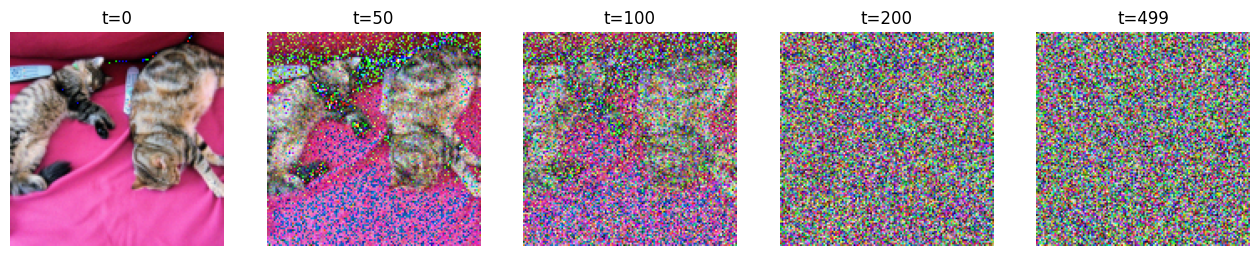

In [ ]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)
# image = Image.open("/data/000000039769.jpg")

image_size = 128
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

x_start = transform(image).unsqueeze(0)

gaussian_diffusion = GaussianDiffusion(timesteps=500)

plt.figure(figsize=(16, 8))
for idx, t in enumerate([0, 50, 100, 200, 499]):
    x_noisy = gaussian_diffusion.q_sample(x_start, t=torch.tensor([t]))
    noisy_image = (x_noisy.squeeze().permute(1, 2, 0) + 1) * 127.5
    noisy_image = noisy_image.numpy().astype(np.uint8)
    plt.subplot(1, 5, 1 + idx)
    plt.imshow(noisy_image)
    plt.axis("off")
    plt.title(f"t={t}")

## 训练

准备数据集

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

In [ ]:
class TrainSet(Dataset):
  def __init__(self, original_dataset,label):
    self.original_dataset = original_dataset
    self.label = label

  def __getitem__(self, index):
      image = self.original_dataset[index]
      return image, self.label[index]

  def __len__(self):
      return len(self.original_dataset)

In [ ]:
class BinaryDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset,indices,label):
        self.original_dataset = original_dataset
        self.indices  = indices
        self.label = label

    def __getitem__(self, index):
        image, _ = self.original_dataset[self.indices[index]]
        return image, self.label

    def __len__(self):
        return len(self.indices)

In [ ]:
batch_size = 64
timesteps = 5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 116582995.42it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24571134.65it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28956168.97it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5122486.90it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
mnist_indices = [i for i in range(len(dataset)) if dataset[i][1] == 3]
mnist2_indices = [i for i in range(len(dataset)) if dataset[i][1] == 2]
dataset_image_number=256

mnist_dataset = BinaryDataset(dataset, mnist_indices[0:dataset_image_number],label=3 )
mnist2_dataset = BinaryDataset(dataset, mnist2_indices[0:dataset_image_number],label=2 )

train_dataset = torch.utils.data.ConcatDataset([mnist_dataset, mnist2_dataset])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=4,pin_memory=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
torch.Size([1, 28, 28])


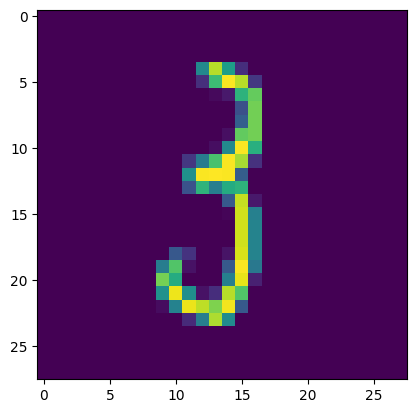

In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[1]
label = train_labels[0]
print(img.size())
plt.imshow(torch.permute(img, (1,2,0)))
plt.show()

模型

开始训练

In [ ]:
import torch,gc
gc.collect()
torch.cuda.empty_cache()
from torch.utils.data import Dataset

In [ ]:
# define model and diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

In [ ]:
epochs = 100
loss_batch_average=torch.zeros([epochs,timesteps,int(dataset_image_number/batch_size)])
model_parameters=dict()

x_t_train_dataset1=torch.utils.data.ConcatDataset([mnist_dataset])
x_t_train_dataset2=torch.utils.data.ConcatDataset([mnist2_dataset])

for t in range(timesteps-1,-1,-1):
  #build the model for each timestep
  model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
  )
  model.to(device)
  optimizer.zero_grad(set_to_none=True)
  torch.cuda.empty_cache()

  time = torch.full((batch_size,),t, device=device).long()
  train_loader1 = torch.utils.data.DataLoader(x_t_train_dataset1, batch_size=batch_size, shuffle=True,pin_memory=True)
  train_loader2 = torch.utils.data.DataLoader(x_t_train_dataset2, batch_size=batch_size, shuffle=True,pin_memory=True)
  for epoch in range(epochs):#256 batch 64
    batch_size=batch_size
    iteration_of_train_loader2=iter(train_loader2)
    for step, (images1, _) in enumerate(train_loader1):

      xt1 = images1.to(device)
      images2,_=next(iteration_of_train_loader2)
      xt2 = images2.to(device)
      #torch.autograd.set_detect_anomaly(True)

      predicted_noise1 = model(xt1, time)
      predicted_noise2 = model(xt2, time)
      out1 = gaussian_diffusion.predict_t_1_from_t(xt1, predicted_noise1 ,t)
      out2 = gaussian_diffusion.predict_t_1_from_t(xt2, predicted_noise2 ,t)
      #loss=0

      m1=out1.reshape(batch_size,28*28)
      m2=out2.reshape(batch_size,28*28)

      difference=m1.mean(0)-m2.mean(0)
      d=difference.t()

      s1=torch.var(m1, dim=0)
      s2=torch.var(m2, dim=0)
      loss1=-torch.log(d.t()@d)
      loss2=torch.log(s1.mean(0)+s2.mean(0))
      loss=loss1+(loss1/loss2).detach()*loss2

      del s1,s2,d,difference
      #sigma_inverse
      print(" this is time ",t," this is epoch",epoch,"this is step ",step)
      print("loss",loss)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_batch_average[epoch,t,step]=loss
      print("loss1",loss1)
      print("loss2",loss2)
      del loss
  #save the model parameters
  model_parameters[t]=model.state_dict()

  x_t_train_dataset1_1=torch.zeros([dataset_image_number,1,28,28])
  x_t_train_dataset2_2=torch.zeros([dataset_image_number,1,28,28])

  labels_1=torch.zeros([dataset_image_number])
  labels_2=torch.zeros([dataset_image_number])

  #establish xt_1 for the next loop
  with torch.no_grad():
    for step, (images1, labels) in enumerate(train_loader1):
      xt1 = images1.to(device)

      predicted_noise = model(xt1, time)
      images1=gaussian_diffusion.predict_t_1_from_t(xt1, predicted_noise,t)

      x_t_train_dataset1_1[step*batch_size:(step+1)*batch_size,:,:,:]=images1
      labels_1[step*batch_size:(step+1)*batch_size]=labels
      del predicted_noise
    x_t_train_dataset1=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset1_1,labels_1)])

  with torch.no_grad():
    for step, (images2, labels2) in enumerate(train_loader2):
      xt2 = images2.to(device)

      predicted_noise2 = model(xt2, time)
      images2=gaussian_diffusion.predict_t_1_from_t(xt2, predicted_noise2,t)

      x_t_train_dataset2_2[step*batch_size:(step+1)*batch_size,:,:,:]=images2
      labels_2[step*batch_size:(step+1)*batch_size]=labels2
      del predicted_noise2

    x_t_train_dataset2=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset2_2,labels_2)])
  del model
  print("done")

#torch.cuda.empty_cache()

流式输出内容被截断，只能显示最后 5000 行内容。
 this is time  3  this is epoch 87 this is step  3
loss tensor(-23.1183, device='cuda:0', grad_fn=<AddBackward0>)
loss1 tensor(-7.7061, device='cuda:0', grad_fn=<NegBackward0>)
loss2 tensor(2.5568, device='cuda:0', grad_fn=<LogBackward0>)
 this is time  3  this is epoch 88 this is step  0
loss tensor(-23.3632, device='cuda:0', grad_fn=<AddBackward0>)
loss1 tensor(-7.7877, device='cuda:0', grad_fn=<NegBackward0>)
loss2 tensor(2.5748, device='cuda:0', grad_fn=<LogBackward0>)
 this is time  3  this is epoch 88 this is step  1
loss tensor(-22.6851, device='cuda:0', grad_fn=<AddBackward0>)
loss1 tensor(-7.5617, device='cuda:0', grad_fn=<NegBackward0>)
loss2 tensor(2.5943, device='cuda:0', grad_fn=<LogBackward0>)
 this is time  3  this is epoch 88 this is step  2
loss tensor(-22.8013, device='cuda:0', grad_fn=<AddBackward0>)
loss1 tensor(-7.6004, device='cuda:0', grad_fn=<NegBackward0>)
loss2 tensor(2.5746, device='cuda:0', grad_fn=<LogBackward0>)
 this is time  3 

torch.Size([100, 5])


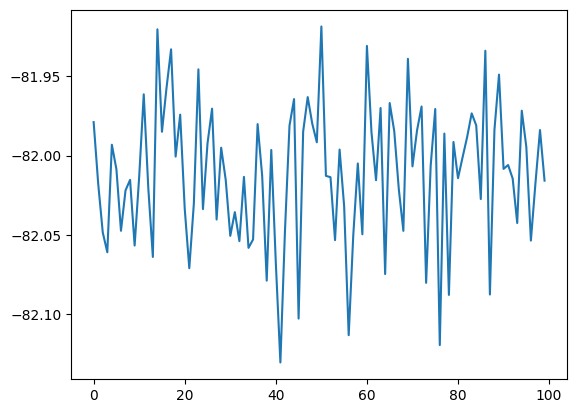

In [ ]:
from logging import StringTemplateStyle
# for timestep=9, plot the average loss function for different batchs
timesteps_list=[i for i in range(0,epochs)]
a=loss_batch_average.mean(2)
print(a.shape)
plt.figure()
plt.plot(timesteps_list,a[:,0].detach().numpy())
plt.show()

torch.Size([100, 5])


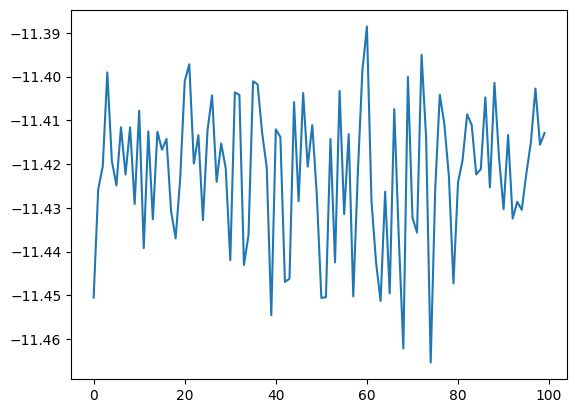

In [ ]:
from logging import StringTemplateStyle
# for timestep=9, plot the average loss function for different batchs
timesteps_list=[i for i in range(0,epochs)]
a=loss_batch_average.mean(2)
print(a.shape)
plt.figure()
plt.plot(timesteps_list,a[:,4].detach().numpy())
plt.show()

torch.Size([100, 5])


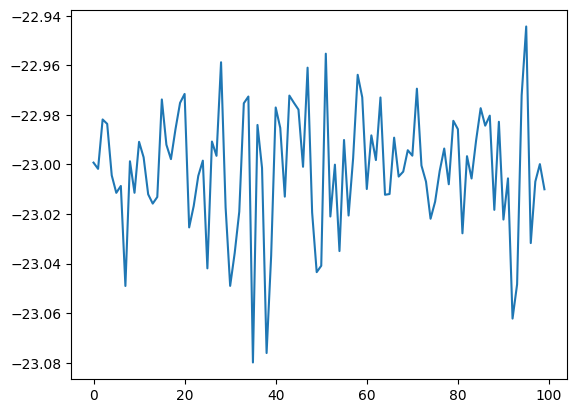

In [ ]:
from logging import StringTemplateStyle
# for timestep=9, plot the average loss function for different batchs
timesteps_list=[i for i in range(0,epochs)]
a=loss_batch_average.mean(2)
print(a.shape)
plt.figure()
plt.plot(timesteps_list,a[:,3].detach().numpy())
plt.show()

## 测试

In [ ]:
# direct calculate the distance and compare them for original images
batch_size=256
train_dataset1 = torch.utils.data.ConcatDataset([mnist_dataset])# this is label 3
train_loader1 = torch.utils.data.DataLoader(train_dataset1, batch_size=batch_size, shuffle=True,pin_memory=True)
x_=torch.zeros([dataset_image_number,1,28,28])
for step, (images, labels) in enumerate(train_loader1):
  with torch.no_grad():
    batch_size = images.shape[0]
    images = images.to(device)
    x_[step*batch_size:(step+1)*batch_size,:,:,:]=images
x_general=x_[0].mean(0)
print(x_general.shape)
print(x_.shape)

torch.Size([28, 28])
torch.Size([256, 1, 28, 28])


In [ ]:
# direct calculate the distance and compare them for original images
batch_size=256
train_dataset2 = torch.utils.data.ConcatDataset([mnist2_dataset])# this is label 2
train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=batch_size, shuffle=True,pin_memory=True)
y_=torch.zeros([dataset_image_number,1,28,28])
for step, (images, labels) in enumerate(train_loader2):
  with torch.no_grad():
    batch_size = images.shape[0]
    images = images.to(device)
    y_[step*batch_size:(step+1)*batch_size,:,:,:]=images
y_general=y_[0].mean(0)
print(y_general.shape)
print(y_.shape)

torch.Size([28, 28])
torch.Size([256, 1, 28, 28])


In [ ]:
# direct calculate the distance and compare them for original images
accuaracy=0
train_dataset = torch.utils.data.ConcatDataset([mnist_dataset, mnist2_dataset])
train_loader11 = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True,num_workers=4,pin_memory=True)

with torch.no_grad():
  for step, (image, label) in enumerate(train_loader11):
    batch_size = image.shape[0]
    image = image.to(device)
    x0=image
    a=torch.norm(x0[0,0,:,:]-x_general.to(device)).to(device)# distance between 3 and pred
    b=torch.norm(x0[0,0,:,:]-y_general.to(device)).to(device)# distance between 2 and pred
    if a >= b:
      pred_label= 2
      #print(a,"and",b)
    else:
      pred_label= 3
      #print(a,"and",b)
    if pred_label==label:
      accuaracy=accuaracy+1
      #print("exact!", pred_label,"the true is ",label)
print(accuaracy/len(train_dataset))

0.798828125


This is the test

In [ ]:
# establish the x0,x1,x2,x3,x4 for class 1 label3
batch_size=256
train_dataset1 = torch.utils.data.ConcatDataset([mnist_dataset])# this is label 3
train_loader1 = torch.utils.data.DataLoader(train_dataset1, batch_size=batch_size, shuffle=True,pin_memory=True)
T=torch.full((batch_size,),timesteps-1, device=device)
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
timsteps=5
model.to(device)
x_1=torch.zeros([timesteps,dataset_image_number,1,28,28])
for step, (images, labels) in enumerate(train_loader1):
  with torch.no_grad():
    batch_size = images.shape[0]
    images = images.to(device)
    x0=images
    for t in range(timesteps-1,-1,-1):
      time = torch.full((batch_size,),t, device=device).long()
      # this is label 3
      model.load_state_dict(model_parameters[t],strict=True)
      model.eval()
      time=torch.full((batch_size,),t, device=device)
      predicted_noiset = model(x0, time)
      x0=gaussian_diffusion.predict_t_1_from_t(x0,predicted_noiset,t)
      x_1[t,step*batch_size:(step+1)*batch_size,:,:,:]=x0
x_1_general=x_1[0].mean(0)
print(x_1_general.shape)
print(x_1.shape)

torch.Size([1, 28, 28])
torch.Size([5, 256, 1, 28, 28])


In [ ]:
# establish the x0,x1,x2,x3,x4 for class 2 label 2
batch_size=256
train_dataset2 = torch.utils.data.ConcatDataset([mnist2_dataset])# this is label 2
train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=batch_size, shuffle=True,pin_memory=True)
T=torch.full((batch_size,),timesteps-1, device=device)
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)
timesteps
x_2=torch.zeros([timesteps,dataset_image_number,1,28,28])
for step, (images, labels) in enumerate(train_loader2):
  with torch.no_grad():
    batch_size = images.shape[0]
    images = images.to(device)
    x0=images
    for t in range(timesteps-1,-1,-1):
      time = torch.full((batch_size,),t, device=device).long()
      # this is label 3
      model.load_state_dict(model_parameters[t],strict=True)
      model.eval()
      time=torch.full((batch_size,),t, device=device)
      predicted_noiset = model(x0, time)
      x0=gaussian_diffusion.predict_t_1_from_t(x0,predicted_noiset,t)
      x_2[t,step*batch_size:(step+1)*batch_size,:,:,:]=x0
x_2_general=x_2[0].mean(0)
print(x_2_general.shape)
print(x_2.shape)

torch.Size([1, 28, 28])
torch.Size([5, 256, 1, 28, 28])


In [ ]:
#calculate the mean distance and variances within differenct class
for t in range(timesteps-1,-1,-1):
  print("distance",torch.norm(x_1[t].mean(0)-x_2[t].mean(0)))
  m1=x_1[t].reshape(batch_size,28*28)
  m2=x_2[t].reshape(batch_size,28*28)

  s1=torch.var(m1, dim=0)
  s2=torch.var(m2, dim=0)
  print("variance",s1.mean(0),s2.mean(0))

distance tensor(16.9552)
variance tensor(0.8381) tensor(0.9374)
distance tensor(44.9779)
variance tensor(6.1519) tensor(7.0559)
distance tensor(474.1280)
variance tensor(707.6345) tensor(803.2369)
distance tensor(885.9354)
variance tensor(2463.4707) tensor(2798.0242)
distance tensor(903.9490)
variance tensor(2564.8835) tensor(2913.1597)


In [ ]:
#T=torch.full((1,),timesteps-1, device=device)
accuaracy=0
train_dataset = torch.utils.data.ConcatDataset([mnist_dataset, mnist2_dataset])
train_loader11 = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True,num_workers=4,pin_memory=True)
acc=torch.zeros(timesteps)
with torch.no_grad():
  for step, (image, label) in enumerate(train_loader11):
    batch_size = image.shape[0]
    image = image.to(device)
    x0=image
    for t in range(timesteps-1,-1,-1):

      model.load_state_dict(model_parameters[t],strict=True)
      model.eval()
      time=torch.full((batch_size,),t, device=device)
      predicted_noiset = model(x0, time)
      x=gaussian_diffusion.predict_t_1_from_t(x0,predicted_noiset,t)
      x_t_train_dataset1=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset1_1,labels_1)])
      x0=x
      a=torch.norm(x0[0,0,:,:]-x_1[t].mean(0)[0,:,:].to(device)).to(device)# distance between 3 and pred
      b=torch.norm(x0[0,0,:,:]-x_2[t].mean(0)[0,:,:].to(device)).to(device)# distance between 2 and pred
      if a >= b:
        pred_label= 2
        #print(a,"and",b)
      else:
        pred_label= 3
        #print(a,"and",b)
        print(pred_label,label)
      if pred_label==label:
        acc[t]=acc[t]+1
      #print("exact!", pred_label,"the true is ",label)
      else:
        print("timestep", t, " find different label at step ", step, pred_label,"the true is ",label)


3 tensor([3])
3 tensor([3])
3 tensor([3])
3 tensor([3])
3 tensor([3])
timestep 4  find different label at step  4 2 the true is  tensor([3])
timestep 3  find different label at step  4 2 the true is  tensor([3])
timestep 2  find different label at step  4 2 the true is  tensor([3])
timestep 1  find different label at step  4 2 the true is  tensor([3])
timestep 0  find different label at step  4 2 the true is  tensor([3])
3 tensor([3])
3 tensor([3])
3 tensor([3])
3 tensor([3])
3 tensor([3])
3 tensor([3])
3 tensor([3])
3 tensor([3])
3 tensor([3])
3 tensor([3])
3 tensor([2])
timestep 4  find different label at step  7 3 the true is  tensor([2])
3 tensor([2])
timestep 3  find different label at step  7 3 the true is  tensor([2])
3 tensor([2])
timestep 2  find different label at step  7 3 the true is  tensor([2])
3 tensor([2])
timestep 1  find different label at step  7 3 the true is  tensor([2])
3 tensor([2])
timestep 0  find different label at step  7 3 the true is  tensor([2])
3 tensor([

In [ ]:
acc/len(train_dataset)

tensor([0.9277, 0.9277, 0.9277, 0.9316, 0.9141])

In [ ]:
# test dataset
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

mnist3_indices_test = [i for i in range(len(test_dataset)) if test_dataset[i][1] == 3]
mnist2_indices_test = [i for i in range(len(test_dataset)) if test_dataset[i][1] == 2]

mnist_dataset_test3 = BinaryDataset(test_dataset, mnist3_indices_test,label=3 )
mnist_dataset_test2 = BinaryDataset(test_dataset, mnist2_indices_test,label=2 )

test_dataset = torch.utils.data.ConcatDataset([mnist_dataset_test3, mnist_dataset_test2])
print(len(mnist3_indices_test)/len(test_dataset))
print(len(mnist2_indices_test)/len(test_dataset))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)


0.49461312438785504
0.5053868756121449


In [ ]:
# test on testset
test_acc=0
with torch.no_grad():
  for step, (image, label) in enumerate(test_loader):
    batch_size = image.shape[0]
    image = image.to(device)
    x0=image
    for t in range(timesteps-1,-1,-1):

      model.load_state_dict(model_parameters[t],strict=True)
      model.eval()
      time=torch.full((batch_size,),t, device=device)
      predicted_noiset = model(x0, time)
      x=gaussian_diffusion.predict_t_1_from_t(x0,predicted_noiset,t)
      x_t_train_dataset1=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset1_1,labels_1)])
      x0=x

    a=torch.norm(x0[0,0,:,:]-x_1_general.to(device)).to(device)# distance between 3 and pred
    b=torch.norm(x0[0,0,:,:]-x_2_general.to(device)).to(device)# distance between 2 and pred
    if a >= b:
      pred_label= 2
      #print(a,"and",b)
    else:
      pred_label= 3
      #print(a,"and",b)
    print(pred_label,label)
    if pred_label==label:
      test_acc=test_acc+1
      #print("exact!", pred_label,"the true is ",label)
    else:
      print("find different label at step ", step, pred_label,"the true is ",label)

print(test_acc/len(test_dataset))

3 tensor([3])
2 tensor([2])
3 tensor([3])
2 tensor([2])
3 tensor([3])
2 tensor([2])
3 tensor([3])
3 tensor([3])
3 tensor([3])
3 tensor([3])
3 tensor([3])
2 tensor([2])
2 tensor([2])
2 tensor([2])
2 tensor([2])
3 tensor([3])
3 tensor([3])
3 tensor([3])
3 tensor([3])
3 tensor([3])
3 tensor([3])
2 tensor([2])
2 tensor([2])
3 tensor([3])
3 tensor([3])
3 tensor([2])
find different label at step  25 3 the true is  tensor([2])
3 tensor([3])
3 tensor([3])
3 tensor([3])
2 tensor([2])
3 tensor([3])
2 tensor([3])
find different label at step  31 2 the true is  tensor([3])
2 tensor([2])
3 tensor([3])
3 tensor([3])
3 tensor([3])
3 tensor([3])
2 tensor([2])
2 tensor([2])
2 tensor([2])
3 tensor([3])
3 tensor([3])
3 tensor([3])
2 tensor([2])
2 tensor([2])
2 tensor([2])
2 tensor([2])
3 tensor([3])
3 tensor([3])
2 tensor([2])
3 tensor([3])
3 tensor([3])
2 tensor([2])
2 tensor([2])
2 tensor([2])
2 tensor([3])
find different label at step  55 2 the true is  tensor([3])
2 tensor([2])
2 tensor([2])
3 tensor

In [ ]:
from sklearn import preprocessing
from sklearn.manifold import TSNE
import torch
import torchvision
import matplotlib.pyplot as plt
def plot(x_t_train_dataset_t,labels_1):
  tsne = TSNE(n_components=2, verbose=1 ,random_state=42)
  x_t_train_dataset_t = x_t_train_dataset_t.view(len(x_t_train_dataset_t), -1)
  result = tsne.fit_transform(x_t_train_dataset_t)
  scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
  result = scaler.fit_transform(result)
  fig = plt.figure(figsize=(5, 5))
  ax = fig.add_subplot()
  ax.set_title('t-SNE process')
  ax.scatter(result[:,0], result[:,1],c=labels_1, s=20)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.001s...
[t-SNE] Computed neighbors for 256 samples in 0.134s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 6.345814
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.260868
[t-SNE] KL divergence after 1000 iterations: 0.643968


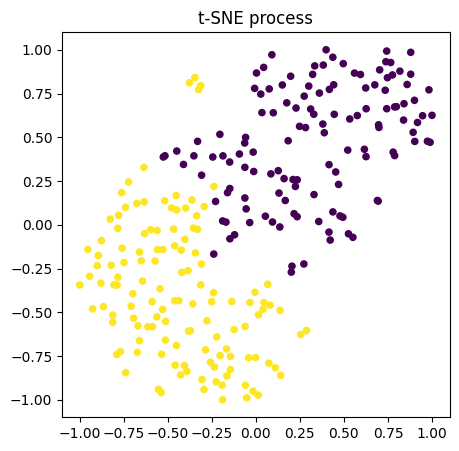

In [ ]:
# This is the visilization of  original images.
t=5
b=256

model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
  )
model.to(device)
train_dataset = torch.utils.data.ConcatDataset([mnist_dataset, mnist2_dataset])
train_loader11 = torch.utils.data.DataLoader(train_dataset, batch_size=b, shuffle=True,num_workers=4,pin_memory=True)

x_t_train_dataset_t=torch.zeros([b,1,28,28])
labels_1=torch.zeros([b])

with torch.no_grad():
  train_loader11 = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=2,pin_memory=True)
  for step, (images1, labels) in enumerate(train_loader11):

    images1=images1.to(device)

    x_t_train_dataset_t[step*batch_size:(step+1)*batch_size,:,:,:]=images1
    labels_1[step*batch_size:(step+1)*batch_size]=labels
  x_t_train_dataset1=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset_t,labels_1)])
  plot(x_t_train_dataset_t,labels_1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.001s...
[t-SNE] Computed neighbors for 256 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 11.523548
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.861305
[t-SNE] KL divergence after 1000 iterations: 0.733544


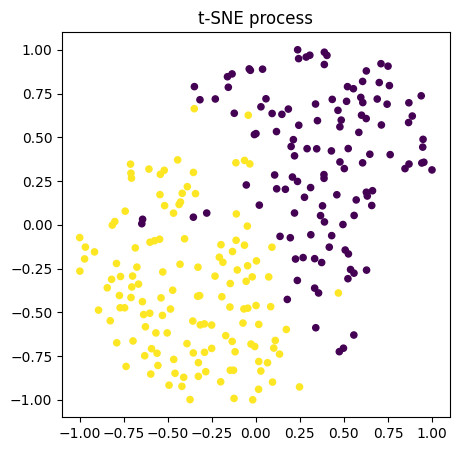

In [ ]:
# This is the first layer.
# for t =4
t=4
b=256

model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
  )
model.to(device)
train_dataset = torch.utils.data.ConcatDataset([mnist_dataset, mnist2_dataset])
train_loader11 = torch.utils.data.DataLoader(train_dataset, batch_size=b, shuffle=True,num_workers=4,pin_memory=True)

x_t_train_dataset_t=torch.zeros([b,1,28,28])
labels_1=torch.zeros([b])

with torch.no_grad():
  train_loader11 = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=2,pin_memory=True)
  for step, (images1, labels) in enumerate(train_loader11):
    xt1 = images1.to(device)
    model.load_state_dict(model_parameters[t],strict=True)
    model.eval()

    predicted_noise = model(xt1, time)
    images1=gaussian_diffusion.predict_t_1_from_t(xt1, predicted_noise,t)

    x_t_train_dataset_t[step*batch_size:(step+1)*batch_size,:,:,:]=images1
    labels_1[step*batch_size:(step+1)*batch_size]=labels
    del predicted_noise
  x_t_train_dataset1=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset_t,labels_1)])
  plot(x_t_train_dataset_t,labels_1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.001s...
[t-SNE] Computed neighbors for 256 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 31.439115
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.015461
[t-SNE] KL divergence after 1000 iterations: 0.735597


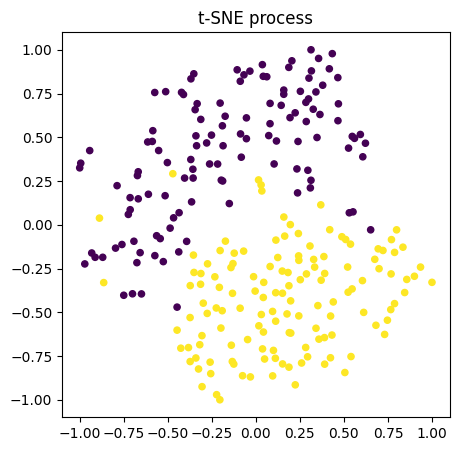

In [ ]:
# This is the second layer.
t=3
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
  )
model.to(device)

x_t_train_dataset_t=torch.zeros([b,1,28,28])
labels_1=torch.zeros([b])

with torch.no_grad():
  train_loader11 = torch.utils.data.DataLoader(x_t_train_dataset1, batch_size=batch_size, shuffle=True,num_workers=2,pin_memory=True)
  for step, (images1, labels) in enumerate(train_loader11):
    xt1 = images1.to(device)
    model.load_state_dict(model_parameters[t],strict=True)
    model.eval()

    predicted_noise = model(xt1, time)
    images1=gaussian_diffusion.predict_t_1_from_t(xt1, predicted_noise,t)

    x_t_train_dataset_t[step*batch_size:(step+1)*batch_size,:,:,:]=images1
    labels_1[step*batch_size:(step+1)*batch_size]=labels
    del predicted_noise
  x_t_train_dataset1=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset_t,labels_1)])
  plot(x_t_train_dataset_t,labels_1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.001s...
[t-SNE] Computed neighbors for 256 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 333.308934
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.003029
[t-SNE] KL divergence after 1000 iterations: 0.791929


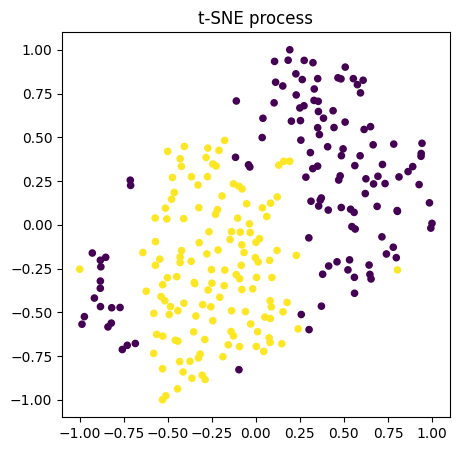

In [ ]:
# This is the third layer.
t=2
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
  )
model.to(device)

x_t_train_dataset_t=torch.zeros([b,1,28,28])
labels_1=torch.zeros([b])

with torch.no_grad():
  train_loader11 = torch.utils.data.DataLoader(x_t_train_dataset1, batch_size=batch_size, shuffle=True,num_workers=2,pin_memory=True)
  for step, (images1, labels) in enumerate(train_loader11):
    xt1 = images1.to(device)
    model.load_state_dict(model_parameters[t],strict=True)
    model.eval()

    predicted_noise = model(xt1, time)
    images1=gaussian_diffusion.predict_t_1_from_t(xt1, predicted_noise,t)

    x_t_train_dataset_t[step*batch_size:(step+1)*batch_size,:,:,:]=images1
    labels_1[step*batch_size:(step+1)*batch_size]=labels
    del predicted_noise
  x_t_train_dataset1=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset_t,labels_1)])
  plot(x_t_train_dataset_t,labels_1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.001s...
[t-SNE] Computed neighbors for 256 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 622.199954
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.189491
[t-SNE] KL divergence after 1000 iterations: 0.771097


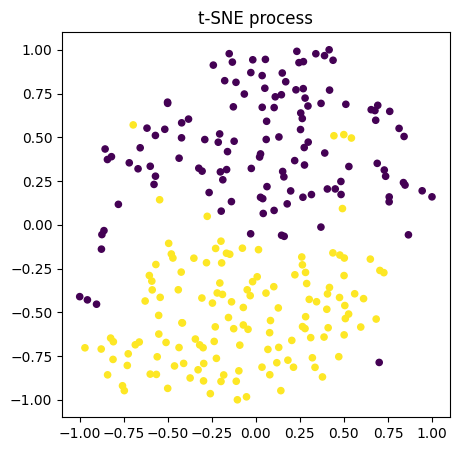

In [ ]:
# This is the fourth layer.
t=1
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
  )
model.to(device)

x_t_train_dataset_t=torch.zeros([b,1,28,28])
labels_1=torch.zeros([b])

with torch.no_grad():
  train_loader11 = torch.utils.data.DataLoader(x_t_train_dataset1, batch_size=batch_size, shuffle=True,num_workers=2,pin_memory=True)
  for step, (images1, labels) in enumerate(train_loader11):
    xt1 = images1.to(device)
    model.load_state_dict(model_parameters[t],strict=True)
    model.eval()

    predicted_noise = model(xt1, time)
    images1=gaussian_diffusion.predict_t_1_from_t(xt1, predicted_noise,t)

    x_t_train_dataset_t[step*batch_size:(step+1)*batch_size,:,:,:]=images1
    labels_1[step*batch_size:(step+1)*batch_size]=labels
    del predicted_noise
  x_t_train_dataset1=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset_t,labels_1)])
  plot(x_t_train_dataset_t,labels_1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.001s...
[t-SNE] Computed neighbors for 256 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 634.865712
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.408455
[t-SNE] KL divergence after 1000 iterations: 0.755320


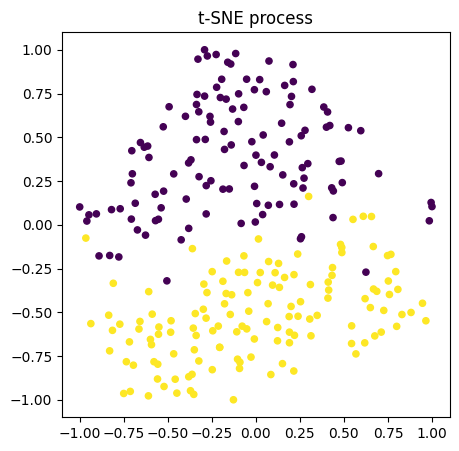

In [ ]:
# This is the 5th layer.
t=0
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
  )
model.to(device)

x_t_train_dataset_t=torch.zeros([b,1,28,28])
labels_1=torch.zeros([b])

with torch.no_grad():
  train_loader11 = torch.utils.data.DataLoader(x_t_train_dataset1, batch_size=batch_size, shuffle=True,num_workers=2,pin_memory=True)
  for step, (images1, labels) in enumerate(train_loader11):
    xt1 = images1.to(device)
    model.load_state_dict(model_parameters[t],strict=True)
    model.eval()

    predicted_noise = model(xt1, time)
    images1=gaussian_diffusion.predict_t_1_from_t(xt1, predicted_noise,t)

    x_t_train_dataset_t[step*batch_size:(step+1)*batch_size,:,:,:]=images1
    labels_1[step*batch_size:(step+1)*batch_size]=labels
    del predicted_noise
  x_t_train_dataset1=torch.utils.data.ConcatDataset([TrainSet(x_t_train_dataset_t,labels_1)])
  plot(x_t_train_dataset_t,labels_1)